In [1]:
import duckdb
from ctypes import *
import numpy as np
from numpy.ctypeslib import ndpointer
import pandas as pd

In [53]:
conn = duckdb.connect("FractalData.duckdb")

# Possible complicated fractals

[np.float64(-0.3493510273253101),
 np.float64(-0.0902082639635403),
 np.float64(-0.7683489630384969),
 np.float64(-0.7337811205448748),
 np.float64(0.5317621601351856),
 np.float64(-0.011690621641083827)]


 [np.float64(0.8339245905900512),
 np.float64(-0.5915660687122912),
 np.float64(0.07382436450987716),
 np.float64(0.05320168977781387),
 np.float64(-1.315562613345942),
 np.float64(0.18151783159808885)]

 [np.float64(0.8342303750538618),
 np.float64(-0.5919808416784739),
 np.float64(0.07720167178040016),
 np.float64(0.043886160120847124),
 np.float64(-1.3142547011775403),
 np.float64(0.18255911418039886)]

In [63]:
conn.close()

In [30]:
coolest = conn.execute("SELECT * FROM SimpleData WHERE coolness = (SELECT MAX(coolness) from SimpleData)").fetchall()

In [23]:
# Get fractal generation functions

fractal_generation_functions = CDLL("C:/Users/aiden/Fractals/Release/fractal_generation.dll")

# Define input and output types for functions with array inputs


fractal_generation_functions.coolness.argtypes = [
    ndpointer(dtype=np.float32, flags="C_CONTIGUOUS"),
    c_int
]
fractal_generation_functions.coolness.restype = c_float


fractal_generation_functions.formattedGreyscaleFractal.argtypes = [
    c_char_p,
    ndpointer(dtype=np.float32, flags="C_CONTIGUOUS"),
    c_int
]
fractal_generation_functions.formattedGreyscaleFractal.restype = int

In [47]:
parameters = np.array(list(coolest[0])[0:-1], dtype=c_float)

In [48]:
parameters

array([-0.62420434, -1.4598112 , -0.21889158,  0.7844356 ,  0.62153316,
       -0.89357144], dtype=float32)

In [41]:
parameters = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=c_float)


fractal_generation_functions.formattedGreyscaleFractal("test.png".encode('utf-8'), parameters, 1000)


fractal_generation_functions.coolness(parameters, 1000)

0.0

In [54]:
result = conn.execute("""
                SELECT 
                    cReal*cReal + cImag*cImag + zbReal*zbReal + zbImag*zbImag + zsReal*zsReal + zsImag*zsImag, 
                    Coolness
                FROM
                    SimpleData
            """).fetchall()


In [90]:
max([r[0] for r in result])

21488

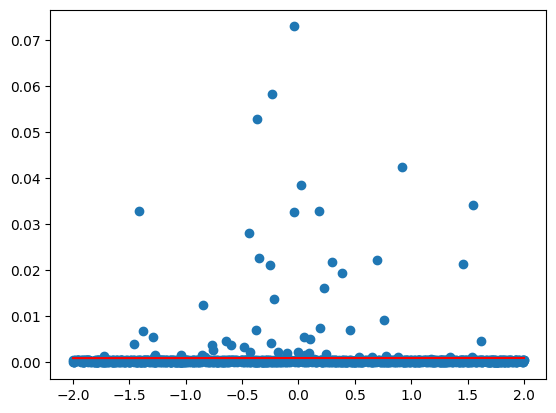

In [62]:
import matplotlib.pyplot as plt

result = conn.execute("""
                SELECT 
                    cImag, 
                    Coolness
                FROM
                    SimpleData
            """).fetchall()

resultX = [r[0] for r in result]
resultY = [r[1] for r in result]

line = np.polyfit(resultX, resultY, deg=1)

xValues = np.linspace(min(resultX),max(resultX))

plt.plot(xValues, [line[0]*x + line[1] for x in xValues], color='red')

plt.scatter(resultX, resultY)

In [64]:
def optimalDirection(originalParameters, delta):

    parameters = originalParameters.copy()

    initialCoolness = Coolness3D(parameters)

    # Change each parameter slightly and find the change in the coolness 
    parameters[0] = originalParameters[0] + delta
    change0 = Coolness3D(parameters) - initialCoolness
    parameters[0] = originalParameters[0]

    parameters[1] = originalParameters[1] + delta
    change1 = Coolness3D(parameters) - initialCoolness
    parameters[1] = originalParameters[1]

    parameters[2] = originalParameters[2] + delta
    change2 = Coolness3D(parameters) - initialCoolness
    parameters[2] = originalParameters[2]

    parameters[3] = originalParameters[3] + delta
    change3 = Coolness3D(parameters) - initialCoolness
    parameters[3] = originalParameters[3]

    parameters[4] = originalParameters[4] + delta
    change4 = Coolness3D(parameters) - initialCoolness
    parameters[4] = originalParameters[4]

    parameters[5] = originalParameters[5] + delta
    change5 = Coolness3D(parameters) - initialCoolness
    parameters[5] = originalParameters[5]

    # Change the parameters proportional to their change, such that the parameters only change with a magnitude of delta
    changeMagnitude = np.sqrt(change0*change0 + change1*change1 + change2*change2 + change3*change3 + change4*change4 + change5*change5)
    return [originalParameters[0] + change0 * delta / changeMagnitude, 
            originalParameters[1] + change1 * delta / changeMagnitude,
            originalParameters[2] + change2 * delta / changeMagnitude,
            originalParameters[3] + change3 * delta / changeMagnitude,
            originalParameters[4] + change4 * delta / changeMagnitude,
            originalParameters[5] + change5 * delta / changeMagnitude,]



def Coolness3D(inp):
    parameters = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=c_float)

    # Generate coefficients 
    parameters[2] = inp[0]
    parameters[3] = inp[1]
    parameters[12] = inp[2]
    parameters[13] = inp[3]
    parameters[18] = inp[4]
    parameters[19] = inp[5]


    return fractal_generation_functions.coolness(np.array(parameters, dtype=c_float), 2048)


def Generate3D(outputFile, inp):
    parameters = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=c_float)

    # Generate coefficients 
    parameters[2] = inp[0]
    parameters[3] = inp[1]
    parameters[12] = inp[2]
    parameters[13] = inp[3]
    parameters[18] = inp[4]
    parameters[19] = inp[5]

    fractal_generation_functions.formattedGreyscaleFractal(outputFile.encode("utf-8"), parameters, 2048)

In [92]:
startingParameters = np.array([1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0], dtype=c_float)

In [93]:
# Do gradient stuff

coolnessHistory = []

parameterHistory = []

iterations = 0

rounds = 0

# Delta = .1
for j in range(10):

    coolnessHistory.append(Coolness3D(betterParameters))
    parameterHistory.append(betterParameters)

    Generate3D("fractalHistory/fractal" + str(rounds) + ".png", betterParameters)
    
    for i in range(5):
        iterations += 1
        print(iterations)
        betterParameters = optimalDirection(betterParameters, 0.1)

    rounds += 1


print("Delta=.1 Done!")


# Delta = .03
for j in range(10):

    coolnessHistory.append(Coolness3D(betterParameters))
    parameterHistory.append(betterParameters)

    Generate3D("fractalHistory/fractal" + str(rounds) + ".png", betterParameters)
    
    for i in range(5):
        iterations += 1
        print(iterations)
        betterParameters = optimalDirection(betterParameters, 0.03)

    rounds += 1


print("Delta=.03 Done!")
    

# Delta = .01
for j in range(10):

    coolnessHistory.append(Coolness3D(betterParameters))
    parameterHistory.append(betterParameters)

    Generate3D("fractalHistory/fractal" + str(rounds) + ".png", betterParameters)
    
    for i in range(5):
        iterations += 1
        print(iterations)
        betterParameters = optimalDirection(betterParameters, 0.01)

    rounds += 1


print("Delta=.01 Done!")    



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Delta=.1 Done!
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Delta=.03 Done!
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144


KeyboardInterrupt: 

In [99]:
betterParameters = parameterHistory[21]


rounds = 0

# Delta = .001
while True:

    coolnessHistory.append(Coolness3D(betterParameters))
    parameterHistory.append(betterParameters)

    Generate3D("fractalHistory/fractal" + str(rounds) + ".png", betterParameters)
    
    for i in range(5):
        iterations += 1
        print(iterations)
        betterParameters = optimalDirection(betterParameters, 0.001)

    rounds += 1


print("Delta=.01 Done!")   

145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374


KeyboardInterrupt: 

In [108]:
betterParameters = parameterHistory[-7]

In [110]:
parameters = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=c_float)

# Generate coefficients 
parameters[2] = betterParameters[0]
parameters[3] = betterParameters[1]
parameters[12] = betterParameters[2]
parameters[13] = betterParameters[3]
parameters[18] = betterParameters[4]
parameters[19] = betterParameters[5]


fractal_generation_functions.formattedGreyscaleFractal("test1.png".encode("utf-8"), parameters, 800)


1